##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.6.0`

In [ ]:
!python --version
!pip freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 30.6MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2ac20aa0b025098bd43103773bcefe91c9c1803fec45f620138aa5e025b5cdac
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



## Get Data

請先到共用雲端硬碟將檔案`flower_data.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1rTfeCpKXoQXI978QiTWC-AI1vwGvd5SU/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq ./drive/My\ Drive/twitter_sentiment.zip

## Loading the dataset


### Custom dataset

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [ ]:
import csv
import os
import numpy as np
import torch
import torchtext
#from torchtext.datasets import text_classification
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# sentence to word 
step 1 分割

stpe 2 放上token 

step 3 設定最大詞句需要多少

step 4 segment 區分不同句子


In [ ]:
class Twitter(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.transform = transform    
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['text'])
                if mode != 'test':
                    self.labels.append(row['sentiment_label'])

    def __getitem__(self, index):
        #self.data_list[index] = str(self.data_list[index])
        encoded_dict = tokenizer.encode_plus(self.data_list[index],add_special_tokens=True,max_length=64,
                              pad_to_max_length=True,return_attention_mask=True,return_tensors='pt')
        sentence = encoded_dict['input_ids'].flatten()
        atten_mask= encoded_dict['attention_mask'].flatten()
        seg_ids =encoded_dict['token_type_ids'].flatten()
        #seg_ids = [0 for _ in range(len(sentence))]
        #sentence = tokenizer.tokenize(self.data_list[index])
        #sentence = ['[CLS]']+sentence+['[SEP]']
        #seg_ids = torch.tensor(seg_ids).unsqueeze(0)
        if self.mode == 'test':

           return sentence,atten_mask,seg_ids,self.data_list[index]
        label = torch.tensor(int(self.labels[index]))
        #MAX_sentence =128 #一句最大128
        #padded_sentence = sentence + ['[PAD]' for _ in range(128 - len(sentence))]
        #attn_mask = [1 if token != '[PAD]' else 0 for token in padded_sentence]
        # 有單詞為1 無單詞為0
        #seg_ids = [0 for _ in range(len(sentence))] #切割不同句子
        #token_ids = tokenizer.convert_tokens_to_ids(padded_sentence)
        #token_ids = torch.tensor(token_ids).unsqueeze(0)
        #atten_mask = torch.tensor(attn_mask).unsqueeze(0)
        return sentence,atten_mask,seg_ids,label

    def __len__(self):
        return len(self.data_list)

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [ ]:
dataset_train = Twitter('./twitter_sentiment/train.csv', mode='train')#, transform=transforms_train)
dataset_val = Twitter('./twitter_sentiment/val.csv', mode='val')#, transform=transforms_test)
dataset_test = Twitter('./twitter_sentiment/test.csv', mode='test')#, transform=transforms_test)

In [ ]:
print("The first token's shape in dataset_train :", dataset_train.__getitem__(1)[0])
print("There are", dataset_train.__len__(), "twitter text in dataset_train.")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


The first token's shape in dataset_train : tensor([  101,  1030,  6892, 16558,  5657,  2190,  2835,  2006,  1037,  1041,
        16147,  2692,  2000,  2604,  2220,  1012,  3201,  1012,  2275,  1012,
         2175,   999,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
There are 10248 twitter text in dataset_train.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [ ]:
from torch.utils.data import DataLoader

# 設定batch數量
batchSizeNums = 64

train_loader = DataLoader(dataset_train, batch_size=batchSizeNums, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batchSizeNums, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batchSizeNums, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

#Deploy model

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer,BertForSequenceClassification,BertConfig
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_labels=3
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',config=config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')#, config=config)
"""
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size,num_labels)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.drop(pooled_output)
    return self.out(pooled_output)
"""
#model=SentimentClassifier(3)
model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Define loss and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions
# Try any loss or optimizer function and learning rate to get better result
# hint: torch.nn and torch.optim
################################################################################
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
learning_rate=1e-5
weight_decay = 1e-2
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
#optimizer  = optim.Adam(bert_model.parameters(), lr=1e-5)
################################################################################
# End of your code
################################################################################
criterion = criterion.cuda()

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)

In [ ]:
# Early Stopping
# 來源: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# mix up寫法
# https://www.kaggle.com/c/bengaliai-cv19/discussion/128592
# !pip install torchtoolbox
# from torchtoolbox.tools import mixup_data, mixup_criterion

In [ ]:
def train(input_data, model, criterion, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    token_ids,atten_mask,seg_ids,label
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0
    for i, data in enumerate(input_data, 0):
        token_ids,atten_mask,labels = data[0].cuda(),data[1].cuda(),data[3].cuda()
        #print(token_ids.size())
        labels = labels.unsqueeze(1)
        #print(atten_mask.size())
        #print(labels.size())
        ########################################################################
        # TODO: Forward, backward and optimize
        # 1. zero the parameter gradients
        # 2. process input through the network
        # 3. compute the loss
        # 4. propagate gradients back into the network’s parameters
        # 5. Update the weights of the network
        ########################################################################
        optimizer.zero_grad()
        outputs = model(token_ids,attention_mask=atten_mask,labels=labels)
        train_loss = outputs.loss#criterion(outputs.loss,labels)
        train_loss.backward()
        optimizer.step()
        ########################################################################
        # End of your code
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images
        # 1. get the model predicted result
        # 2. sum the number of this batch predicted images
        # 3. sum the number of correctly classified
        # 4. save this batch's loss into loss_list
        # dimension of outputs: [batch_size, number of classes]
        # Hint 1: use outputs.data to get no auto_grad
        # Hint 2: use torch.max()
        ########################################################################
        y_pred_prob = outputs[1]
        y_pred_label = y_pred_prob.argmax(dim=1)
        #_, predicted = torch.max(outputs[1], 1)
        #print(y_pred_label)
        #print(labels)
        total_count += len(labels)
        acc_count += (y_pred_label == labels).int().sum()
        loss_list.append(train_loss.item())
        ########################################################################
        # End of your code
        ########################################################################

    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [ ]:
def val(input_data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for data in input_data:
            token_ids,atten_mask,labels = data[0].cuda(),data[1].cuda(),data[3].cuda()
            labels = labels.unsqueeze(1)

            ####################################################################
            # TODO: Get the predicted result and loss
            # 1. process input through the network
            # 2. compute the loss
            # 3. get the model predicted result
            # 4. get the counts of correctly classified images
            # 5. save this batch's loss into loss_list attention_mask=atten_mask,
            ####################################################################
            outputs = model(token_ids,attention_mask=atten_mask,labels=labels)
            val_loss = outputs.loss#criterion(outputs,labels)
            y_pred_prob = outputs[1]
            y_pred_label = y_pred_prob.argmax(dim=1)
            #predicted = torch.max(outputs, 1)[1]
            total_count += len(labels)
            acc_count += (y_pred_label == labels).int().sum()
            loss_list.append(val_loss.item())
            ####################################################################
            # End of your code
            ####################################################################

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [ ]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 4
log_interval = 2              # print acc and loss in per log_interval time
early_stopping_patience = 30
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=False)

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_loader,model, criterion, optimizer)
    val_acc, val_loss = val(val_loader, model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_loss))
    
    # 判斷是否達到Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


==================== Epoch 2 ====================
Train Acc: 30.586748 Train Loss: 0.405914
  Val Acc: 30.256830   Val Loss: 0.406030
EarlyStopping counter: 1 out of 30
==================== Epoch 4 ====================
Train Acc: 30.176424 Train Loss: 0.273423
  Val Acc: 30.475409   Val Loss: 0.442857
EarlyStopping counter: 2 out of 30


<All keys matched successfully>

#### Visualize accuracy and loss

In [ ]:
best_epoch = val_loss_list.index(min(val_loss_list))
print('Early Stopping Epoch:', best_epoch)
print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc_list[best_epoch], train_loss_list[best_epoch]))
print('  Val Acc: {:.6f}   Val Loss: {:.6f}'.format(val_acc_list[best_epoch], val_loss_list[best_epoch]))

Early Stopping Epoch: 1
Train Acc: 30.586748 Train Loss: 0.405914
  Val Acc: 30.256830   Val Loss: 0.406030


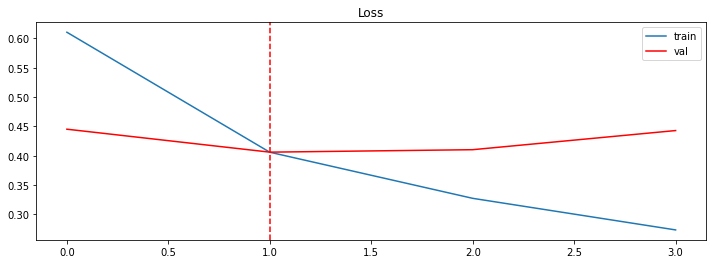

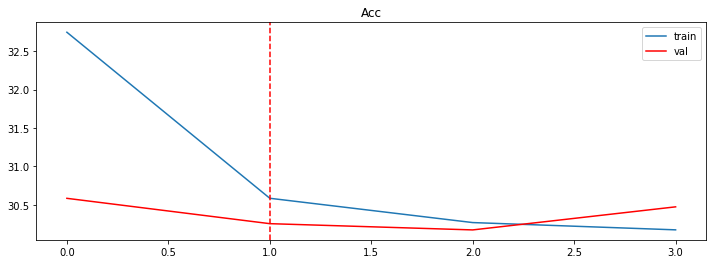

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.axvline(best_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.axvline(best_epoch, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.show()

### Predict Result

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/t/a16786b7da97419f9ba90b495dab08aa)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    text = []
    with torch.no_grad():
        for data in input_data:
            token_ids,atten_mask,segments_tensors,senten= data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3]
            print(segments_tensors)
            #labels = labels.unsqueeze(1)
            #segments_tensors = segments_tensors.flatten()
            outputs = model(token_ids,token_type_ids=segments_tensors,attention_mask=atten_mask)
            y_pred_prob = outputs[0]
            y_pred_label = y_pred_prob.argmax(dim=1)
            #outputs = model(images)
            #_, predicted = torch.max(outputs.data, 1)
            output_list.extend(y_pred_label.to('cpu').numpy().tolist())
            for r in (senten):
              text.append(r)
    return output_list,text

In [ ]:
output_csv,text = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['index','sentiment_label'])
    writer.writeheader()
    idx = 0
    #'text' :text[idx] ,
    for result in output_csv:
        writer.writerow({'index':idx,'sentiment_label':result})
        idx+=1


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0,